Make a simple model for object detection, train it, and test it.  

- Model  
  - CNN several layers + fc
- Dataset
  - Made from MSCOCO dataset

In [1]:
from TKM.OD import modeling
import torch
from torch.utils.data import DataLoader

### DATASET

In [2]:
# datasets.yaml loaded
import yaml,json
with open("datasets.yaml","r") as f:
    datasets_cfg = yaml.safe_load(f)

# mscoco.one_person dataset
one_person_datasets_cfg = datasets_cfg['mscoco']['one_person']
json_path = one_person_datasets_cfg['annotation']
img_dir = one_person_datasets_cfg['image_dir']


In [3]:
# dataset[i]['image'] = np.array([]) 3rd order tensor
# dataset[i]['bbox'] = (x,y,w,h)
IMAGE_SIZE=(32,32)
RESIZE=True

from pycocotools.coco import COCO
import os
import cv2
from tqdm import tqdm
from PIL import Image
import torchvision.transforms as transforms

coco = COCO(json_path)

with open(json_path,"r") as f:
    anns = json.load(f)

image_ids = [image['id'] for image in anns['images']]
dataset = list()
# i,image_ids, anns['images'] is in the same order
for i,id in tqdm(enumerate(image_ids)):
    data = dict()
    
    # dataset['image']
    file_name = anns['images'][i]['file_name']
    file_path = os.path.join(img_dir,file_name)
    image = Image.open(file_path)
    if RESIZE:
        original_image_size = image.size
        image = image.resize(IMAGE_SIZE)

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize([0,0,0],[1,1,1])
    ])
    # Some images are gray scale
    if image.mode == 'L':
        image = image.convert("RGB")
    image = transform(image)
    
    data['image'] = image #torch.tensor(image,dtype=torch.float).transpose(0,2).transpose(1,2)

    # dataset['bbox']
    AnnIds = coco.getAnnIds(id,catIds=1)
    data['bbox'] = torch.tensor(coco.loadAnns(AnnIds)[0]['bbox'],dtype=torch.float)
    if RESIZE:
        data['bbox'][0] = data['bbox'][0] * IMAGE_SIZE[1] / original_image_size[1] # なぜかx,y が逆、、、
        data['bbox'][1] = data['bbox'][1] * IMAGE_SIZE[0] / original_image_size[0]
        data['bbox'][2] = data['bbox'][2] * IMAGE_SIZE[1] / original_image_size[1]
        data['bbox'][3] = data['bbox'][3] * IMAGE_SIZE[0] / original_image_size[0]
    dataset.append(data)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


1079it [00:08, 123.10it/s]


In [4]:
# check data['image','bbox']
CHECK_DATA=False

if CHECK_DATA:
    import numpy as np
    import matplotlib.pyplot as plt

    image_show = np.array(data['image'].transpose(0,1).transpose(0,2),dtype=int) # (M,N,3) format
    image_show = image_show[:,:,[2,1,0]] # RGB->BGR 
    plt.imshow(image_show)

    # show bbox
    x,y,w,h = data['bbox']
    plt.plot([x,x+w,x+w,x,x],[y,y,y+h,y+h,y],color='black')

### Dataset split into train and test (8:2)

In [5]:
perm = torch.randperm(len(dataset))
train_num = int(len(dataset)*0.8)
train_dataset = torch.utils.data.Subset(dataset,indices=perm[:train_num])
test_dataset = torch.utils.data.Subset(dataset,indices=perm[train_num:])

### DataLoader

In [6]:
batch_size=4
train_loader= DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader= DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

#### MODEL

In [7]:
model = modeling.SimpleObjectDetector()
x = torch.randn(4,3,32,32) # 3色 32*32画像 
model(x)

tensor([[14.6915, 17.0905, 14.7551, 17.3990],
        [14.2845, 16.9271, 14.8569, 17.2802],
        [14.2239, 17.7656, 14.4430, 17.0719],
        [13.9917, 17.1841, 14.4879, 17.8320]], grad_fn=<AddBackward0>)

In [8]:
# check model
import torchsummary
model.cuda()
torchsummary.summary(model,(3,32,32),device="cuda")

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 32, 32]             224
              ReLU-2            [-1, 8, 32, 32]               0
         MaxPool2d-3            [-1, 8, 16, 16]               0
         ConvLayer-4            [-1, 8, 16, 16]               0
            Conv2d-5           [-1, 16, 16, 16]           1,168
              ReLU-6           [-1, 16, 16, 16]               0
         MaxPool2d-7             [-1, 16, 8, 8]               0
         ConvLayer-8             [-1, 16, 8, 8]               0
            Linear-9                 [-1, 1024]       1,049,600
             ReLU-10                 [-1, 1024]               0
           Linear-11                 [-1, 1024]       1,049,600
             ReLU-12                 [-1, 1024]               0
           Linear-13                    [-1, 4]           4,100
Total params: 2,104,692
Trainable param

In [9]:
import torch.nn as nn
from TKM.OD import metrics
import sys

# return the trained model
def experiment(loss_index=0,epoch_num=10,model_initialize=False,model=None,show_progress=False):

    if model_initialize:
        model = modeling.SimpleObjectDetector()
        model.cuda()
    
    optimizer = torch.optim.SGD(model.parameters(),lr=0.01,momentum=0.9)

    from time import time

    criterion = nn.L1Loss()
    if torch.cuda.is_available():
        criterion.cuda()

    model.train()
    start = time()
    for epoch in range(1,epoch_num+1):
        sum_loss = 0
        sum_IoU = 0

        model.train()

        for data in train_loader:
            image = data['image']
            bbox = data['bbox']
            image = image.cuda()
            bbox = bbox.cuda()

            pred = model(image)
            # print(pred[0].tolist())

            loss = criterion(bbox,pred)
            model.zero_grad()
            loss.backward()
            optimizer.step()

            sum_loss += loss.item()
            sum_IoU += metrics.IoU(bbox,pred).sum()
        if show_progress:
            print("epoch: {}, mean_loss: {}, mean_IoU: {}, elapsed_time: {}".format(epoch, sum_loss/(len(train_loader)*batch_size),
                                                                    sum_IoU/(len(train_loader)*batch_size),
                                                                    time() - start  ))
        
        # test
        model.eval()
        for data in test_loader:
            image = data['image']
            bbox = data['bbox']
            image = image.cuda()
            bbox = bbox.cuda()

            pred = model(image)

            if loss_index==0:
                loss = criterion(bbox,pred)
            elif loss_index==1:
                loss = criterion(bbox,pred) + metrics.IoU(bbox,pred).sum()
            elif loss_index==2:
                loss = metrics.IoU(bbox,pred).sum()
            else:
                print("loss not implemented error")
                sys.exit(1)

            sum_loss += loss.item()
            sum_IoU += metrics.IoU(bbox,pred).sum()

        if show_progress:
            print("epoch: {}, mean_loss: {}, mean_IoU: {}, elapsed_time: {}".format(epoch, sum_loss/(len(train_loader)*batch_size),
                                                                    sum_IoU/(len(train_loader)*batch_size),
                                                                    time() - start  )) 
    return model      

### Training and test

epoch: 1, mean_loss: 2.3250293731689453, mean_IoU: 0.10512737184762955, elapsed_time: 0.5112247467041016
epoch: 1, mean_loss: 2.926850395622077, mean_IoU: 0.11620541661977768, elapsed_time: 0.5876286029815674
epoch: 2, mean_loss: 2.2394313602535814, mean_IoU: 0.10785976052284241, elapsed_time: 0.9939830303192139
epoch: 2, mean_loss: 2.7193630155589847, mean_IoU: 0.15252095460891724, elapsed_time: 1.0476374626159668
epoch: 3, mean_loss: 2.3006453453390687, mean_IoU: 0.11397141218185425, elapsed_time: 1.458397626876831
epoch: 3, mean_loss: 2.831743625579057, mean_IoU: 0.14834018051624298, elapsed_time: 1.5106511116027832
epoch: 4, mean_loss: 2.222621578309271, mean_IoU: 0.11815915256738663, elapsed_time: 1.9187729358673096
epoch: 4, mean_loss: 2.750649420199571, mean_IoU: 0.1386832594871521, elapsed_time: 1.969897747039795
epoch: 5, mean_loss: 2.3576246949809567, mean_IoU: 0.09973643720149994, elapsed_time: 2.3862698078155518
epoch: 5, mean_loss: 2.8839557907647557, mean_IoU: 0.138591468

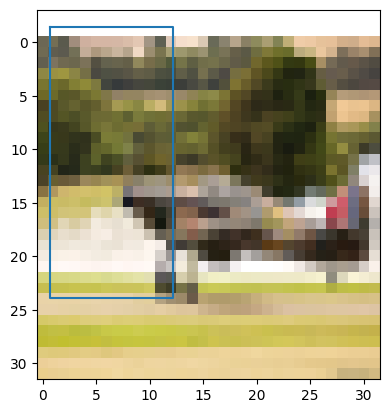

loss:8.140748023986816 
IoU:tensor([0.0000, 0.2675, 0.0000, 0.2223], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([ 0.6560, -1.4120, 11.4917, 25.3428], grad_fn=<ToCopyBackward0>)
tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 0.6560020446777344 -1.4119987487792969 11.491705894470215 25.34282112121582


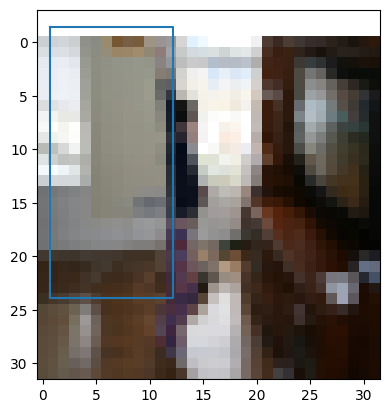

loss:8.442235946655273 
IoU:tensor([0.0480, 0.0051, 0.5364, 0.0402], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([ 0.6560, -1.4120, 11.4917, 25.3428], grad_fn=<ToCopyBackward0>)
tensor(0.0480, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 0.6560020446777344 -1.4119987487792969 11.491705894470215 25.34282112121582


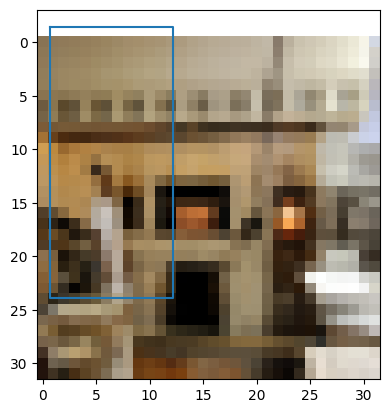

loss:10.833601951599121 
IoU:tensor([0.0000, 0.0000, 0.0000, 0.2330], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([ 0.6560, -1.4120, 11.4917, 25.3428], grad_fn=<ToCopyBackward0>)
tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 0.6560020446777344 -1.4119987487792969 11.491705894470215 25.34282112121582


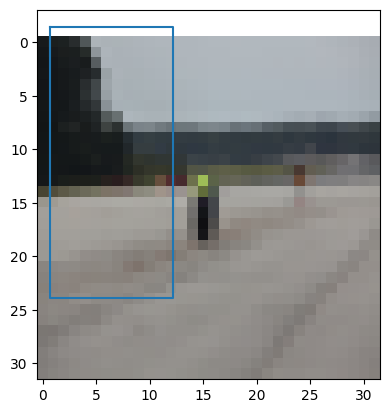

loss:11.818532943725586 
IoU:tensor([0.0000, 0.0000, 0.0000, 0.1383], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([ 0.6560, -1.4120, 11.4917, 25.3428], grad_fn=<ToCopyBackward0>)
tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 0.6560020446777344 -1.4119987487792969 11.491705894470215 25.34282112121582


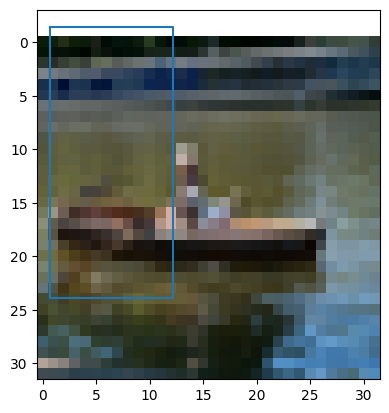

loss:8.8287992477417 
IoU:tensor([0.3351, 0.2225, 0.0000, 0.2976], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([ 0.6560, -1.4120, 11.4917, 25.3428], grad_fn=<ToCopyBackward0>)
tensor(0.3351, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 0.6560020446777344 -1.4119987487792969 11.491705894470215 25.34282112121582


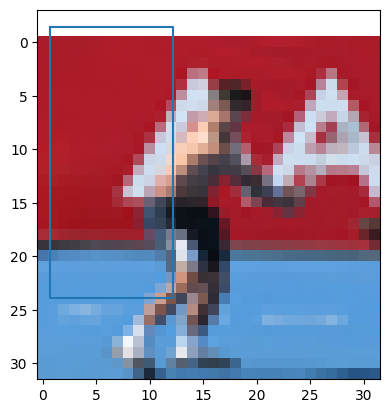

loss:7.287362575531006 
IoU:tensor([0.5428, 0.3504, 0.0000, 0.4142], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([ 0.6560, -1.4120, 11.4917, 25.3428], grad_fn=<ToCopyBackward0>)
tensor(0.5428, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 0.6560020446777344 -1.4119987487792969 11.491705894470215 25.34282112121582


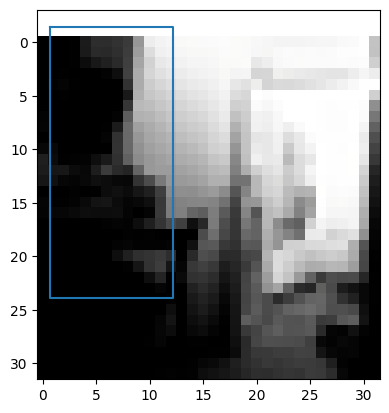

<Figure size 640x480 with 0 Axes>

In [10]:
# with training, check the prediction
model = experiment(loss_index=0,epoch_num=10,model_initialize=True,show_progress=True)

# show the model
criterion = nn.L1Loss()
model.eval()
for i,data in enumerate(test_loader):
    image = data['image']
    bbox = data['bbox']
    image = image.cuda()
    bbox = bbox.cuda()

    pred = model(image)

    loss = criterion(pred,bbox)
    IoU = metrics.IoU(pred,bbox)
    print(f"loss:{loss} \nIoU:{IoU}")
    

    # show the first ones of each batch
    import numpy as np
    import matplotlib.pyplot as plt

    number = 0 # 0~batch_size

    image_ = image[number]
    image_ = image_.cpu()
    image_show = np.array(image_.transpose(0,2).transpose(0,1)*255,dtype=int)

    plt.imshow(image_show)

    bbox = pred[number].cpu()
    print("predicted bbox:",bbox)
    x,y,w,h = bbox.tolist()
    plt.plot([x,x+w,x+w,x,x],[y,y,y+h,y+h,y])
    print(IoU[number])
    print("predicted bbox:",x,y,w,h)
    plt.show()
    plt.clf()

    if i > 5:
        break

I can see all the predicted bbox is almost the same for all images.

#### Additional Study

loss:8.746334075927734 
IoU:tensor([0.0199, 0.2791, 0.0039, 0.0000], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([15.7005, 15.5975, 16.0716, 16.0678], grad_fn=<ToCopyBackward0>)
tensor(0.0199, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 15.700479507446289 15.597489356994629 16.07158660888672 16.067813873291016


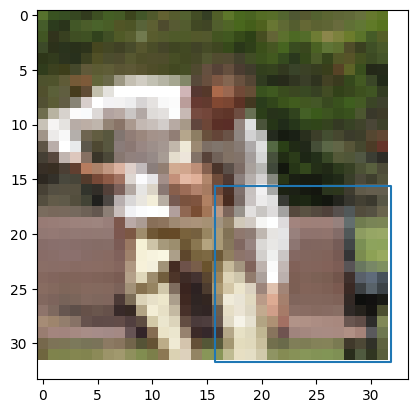

loss:7.023305892944336 
IoU:tensor([0.3200, 0.0261, 0.1797, 0.0168], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([15.4646, 15.8898, 15.8203, 16.1895], grad_fn=<ToCopyBackward0>)
tensor(0.3200, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 15.464628219604492 15.889793395996094 15.820300102233887 16.18954086303711


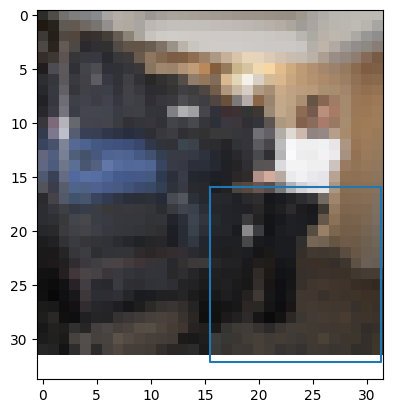

loss:8.794028282165527 
IoU:tensor([0.0000, 0.0000, 0.0366, 0.1985], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([15.6553, 15.9164, 15.9708, 16.0991], grad_fn=<ToCopyBackward0>)
tensor(0., device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 15.655303955078125 15.91637897491455 15.970780372619629 16.099130630493164


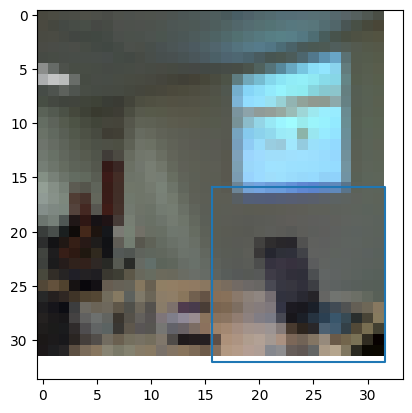

loss:10.798200607299805 
IoU:tensor([0.1210, 0.0722, 0.0585, 0.0425], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([15.5071, 15.5972, 16.1133, 16.1550], grad_fn=<ToCopyBackward0>)
tensor(0.1210, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 15.50706958770752 15.597247123718262 16.1132755279541 16.15496253967285


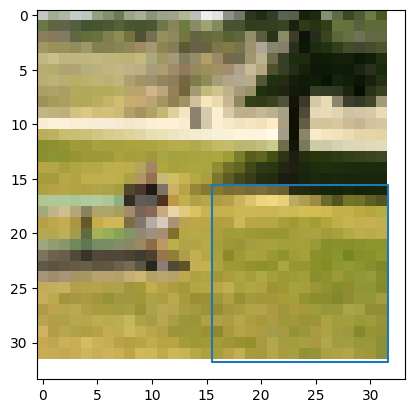

loss:7.618191719055176 
IoU:tensor([0.0163, 0.0000, 0.0689, 0.1273], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([15.4876, 15.5825, 16.0382, 16.1418], grad_fn=<ToCopyBackward0>)
tensor(0.0163, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 15.487568855285645 15.582523345947266 16.038204193115234 16.141786575317383


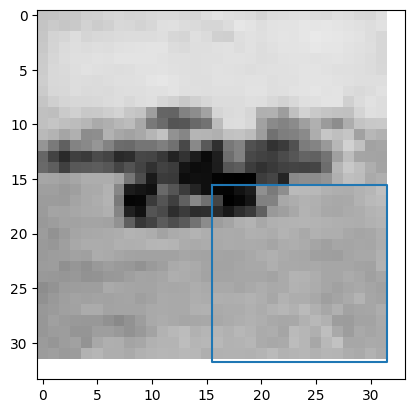

loss:12.555608749389648 
IoU:tensor([0.0165, 0.0590, 0.0423, 0.0802], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([15.4495, 15.7822, 15.7847, 16.0746], grad_fn=<ToCopyBackward0>)
tensor(0.0165, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 15.449496269226074 15.782190322875977 15.784701347351074 16.074604034423828


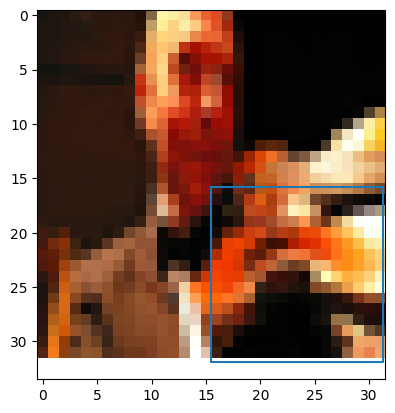

loss:9.646699905395508 
IoU:tensor([0.0063, 0.0544, 0.0000, 0.3169], device='cuda:0',
       grad_fn=<DivBackward0>)
predicted bbox: tensor([15.5010, 15.9340, 15.8475, 15.9832], grad_fn=<ToCopyBackward0>)
tensor(0.0063, device='cuda:0', grad_fn=<SelectBackward0>)
predicted bbox: 15.500951766967773 15.933981895446777 15.847519874572754 15.983208656311035


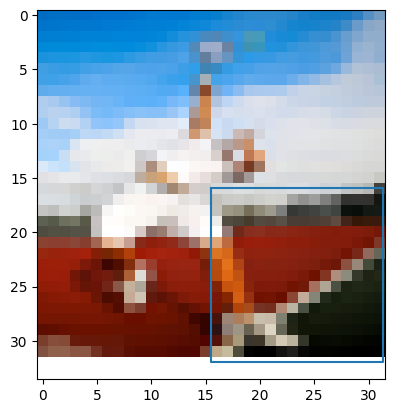

<Figure size 640x480 with 0 Axes>

In [11]:
# without training, check the prediction
model = experiment(loss_index=2,epoch_num=0,model_initialize=True,model=model)

# show the model
criterion = nn.L1Loss()
model.eval()
for i,data in enumerate(test_loader):
    image = data['image']
    bbox = data['bbox']
    image = image.cuda()
    bbox = bbox.cuda()

    pred = model(image)

    loss = criterion(pred,bbox)
    IoU = metrics.IoU(pred,bbox)
    print(f"loss:{loss} \nIoU:{IoU}")
    

    # show the first ones of each batch
    import numpy as np
    import matplotlib.pyplot as plt

    number = 0 # 0~batch_size

    image_ = image[number]
    image_ = image_.cpu()
    image_show = np.array(image_.transpose(0,2).transpose(0,1)*255,dtype=int)

    plt.imshow(image_show)

    bbox = pred[number].cpu()
    print("predicted bbox:",bbox)
    x,y,w,h = bbox.tolist()
    plt.plot([x,x+w,x+w,x,x],[y,y,y+h,y+h,y])
    print(IoU[number])
    print("predicted bbox:",x,y,w,h)
    plt.show()
    plt.clf()

    if i > 5:
        break

I can see all the predicted bbox are almost the same even without training